In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from random import randrange
import random
from pprint import pprint

In [537]:
def check_purity(data):
#     label_column = data[:, -1] #getting the label column for the data
#     unique_classes = np.unique(label_column)
    classes = np.unique(data[:, -1]) #getting the unique classes for the data


    if len(classes) == 1: #chceking purity
        return True
    else:
        return False

In [538]:
def create_leaf(data, ml_task):
    label_column = data[:, -1]
    if ml_task == "regression":
        leaf = np.mean(label_column)
        
    # classfication    
    else:
        unique_classes, counts_unique_classes = np.unique(label_column, return_counts=True)
        index = counts_unique_classes.argmax()
        leaf = unique_classes[index]
    
    return leaf

In [539]:
def get_potential_splits(data, random_subspace):
    
    potential_splits = {}
    _, n_columns = data.shape
    column_indices = list(range(n_columns - 1))    # excluding the last column which is the label
    
    if random_subspace and random_subspace <= len(column_indices):
        column_indices = random.sample(population=column_indices, k=random_subspace)
    
    for column_index in column_indices:          
        values = data[:, column_index]
        unique_values = np.unique(values)
        
        potential_splits[column_index] = unique_values
    
    return potential_splits

In [540]:
def split_data(data, split_column, split_value):
    
    split_column_values = data[:, split_column]

    type_of_feature = FEATURE_TYPES[split_column]
    if type_of_feature == "continuous":
        data_below = data[split_column_values <= split_value]
        data_above = data[split_column_values >  split_value]
    
    # feature is categorical   
    else:
        data_below = data[split_column_values == split_value]
        data_above = data[split_column_values != split_value]
    
    return data_below, data_above

In [541]:
def calculate_mse(data):
    actual_values = data[:, -1]
    if len(actual_values) == 0:   # empty data
        mse = 0
        
    else:
        prediction = np.mean(actual_values)
        mse = np.mean((actual_values - prediction) **2)
    
    return mse

In [542]:
def calculate_entropy(data):
    
    label_column = data[:, -1]
    _, counts = np.unique(label_column, return_counts=True)

    probabilities = counts / counts.sum()
    entropy = sum(probabilities * -np.log2(probabilities))
     
    return entropy

In [543]:
def calculate_overall_metric(data_below, data_above, metric_function):
    
    n = len(data_below) + len(data_above)
    p_data_below = len(data_below) / n
    p_data_above = len(data_above) / n

    overall_metric =  (p_data_below * metric_function(data_below) 
                     + p_data_above * metric_function(data_above))
    
    return overall_metric

In [544]:
def determine_best_split(data, potential_splits, ml_task):
    
    first_iteration = True
    for column_index in potential_splits:
        for value in potential_splits[column_index]:
            data_below, data_above = split_data(data, split_column=column_index, split_value=value)
            
            if ml_task == "regression":
                current_overall_metric = calculate_overall_metric(data_below, data_above, metric_function=calculate_mse)
            
            # classification
            else:
                current_overall_metric = calculate_overall_metric(data_below, data_above, metric_function=calculate_entropy)

            if first_iteration or current_overall_metric <= best_overall_metric:
                first_iteration = False
                
                best_overall_metric = current_overall_metric
                best_split_column = column_index
                best_split_value = value
    
    return best_split_column, best_split_value

In [545]:
def determine_type_of_feature(df):
    
    feature_types = []
    n_unique_values_treshold = 15
    for feature in df.columns:
        if feature != "label":
            unique_values = df[feature].unique()
            example_value = unique_values[0]

            if (isinstance(example_value, str)) or (len(unique_values) <= n_unique_values_treshold):
                feature_types.append("categorical")
            else:
                feature_types.append("continuous")
    
    return feature_types

In [546]:
def decision_tree_algorithm(df, ml_task, counter=0, min_samples=2, max_depth=5,random_subspace=None):
    
    # data preparations
    if counter == 0:
        global COLUMN_HEADERS, FEATURE_TYPES
        COLUMN_HEADERS = df.columns
        FEATURE_TYPES = determine_type_of_feature(df)
        data = df.values
    else:
        data = df           
    
    
    # base cases
    if (check_purity(data)) or (len(data) < min_samples) or (counter == max_depth):
        leaf = create_leaf(data, ml_task)
        return leaf

    
    # recursive part
    else:    
        counter += 1

        # helper functions 
        potential_splits = get_potential_splits(data,random_subspace)
        split_column, split_value = determine_best_split(data, potential_splits, ml_task)
        data_below, data_above = split_data(data, split_column, split_value)
        
        # check for empty data
        if len(data_below) == 0 or len(data_above) == 0:
            leaf = create_leaf(data, ml_task)
            return leaf
        
        # determine question
        feature_name = COLUMN_HEADERS[split_column]
        type_of_feature = FEATURE_TYPES[split_column]
        if type_of_feature == "continuous":
            question = "{} <= {}".format(feature_name, split_value)
            
        # feature is categorical
        else:
            question = "{} = {}".format(feature_name, split_value)
        
        # instantiate sub-tree
        sub_tree = {question: []}
        
        # find answers (recursion)
        yes_answer = decision_tree_algorithm(data_below, ml_task, counter, min_samples, max_depth,random_subspace)
        no_answer = decision_tree_algorithm(data_above, ml_task, counter, min_samples, max_depth,random_subspace)
        
        # If the answers are the same, then there is no point in asking the qestion.
        # This could happen when the data is classified even though it is not pure
        # yet (min_samples or max_depth base case).
        if yes_answer == no_answer:
            sub_tree = yes_answer
        else:
            sub_tree[question].append(yes_answer)
            sub_tree[question].append(no_answer)
        
        return sub_tree

In [547]:
def predict_example(example, tree):
    
    question = list(tree.keys())[0]
    feature_name, comparison_operator, value = question.split(" ")

    # ask question
    if comparison_operator == "<=":
        if example[feature_name] <= float(value):
            answer = tree[question][0]
        else:
            answer = tree[question][1]
    
    # feature is categorical
    else:
        if str(example[feature_name]) == value:
            answer = tree[question][0]
        else:
            answer = tree[question][1]

    # base case
    if not isinstance(answer, dict):
        return answer
    
    # recursive part
    else:
        residual_tree = answer
        return predict_example(example, residual_tree)

In [548]:
def calculate_r_squared(df, tree):    
    labels = df.label
    #mean = labels.mean()
    predictions = df.apply(predict_example, args=(tree,), axis=1)
    ss_res = sum((labels - predictions) ** 2)
    mse=ss_res/len(labels)
    mean_=np.mean(labels - predictions)
    std_=np.std(labels - predictions)
    
    #ss_tot = sum((labels - mean) ** 2)
    #r_squared = 1 - ss_res / ss_tot
    return mse,mean_,std_
   # return r_squared

In [549]:
def calculate_accuracy(df, tree):

    df["classification"] = df.apply(predict_example, axis=1, args=(tree,))
    df["classification_correct"] = df["classification"] == df["label"]
    
    accuracy = df["classification_correct"].mean()
    
    return accuracy

# Classification

In [550]:
data_class=pd.read_csv("PRSA_data_2010.1.1-2014.12.31.csv",header=[0])
print("Data Shape:",data_class.shape)
data_class = data_class.drop("No", axis=1)
data_class = data_class.rename(columns={"month": "label"})
data_new['label']=data_class['label']
data_class=data_class.drop('label', axis=1)
print("Data Shape:",data_class.shape)
data_class['label']=data_new['label']
data_class=data_class.fillna(data_class.mean())
train_dataframe_class=data_class.loc[data_class['year'].isin(['2010','2012'])]
test_dataframe_class=data_class.loc[data_class['year'].isin(['2011','2013'])]
print("Training shape:",train_dataframe_class.shape)
print("Testing shape:",test_dataframe_class.shape)

Data Shape: (43824, 13)
Data Shape: (43824, 11)
Training shape: (17544, 12)
Testing shape: (17520, 12)


In [551]:
tree_class = decision_tree_algorithm(train_dataframe_class, ml_task="classification")
accuracy = calculate_accuracy(test_dataframe_class, tree_class)
print("Accuracy:",accuracy)

{'TEMP <= 11.0': [{'TEMP <= 1.0': [{'DEWP <= -11': [{'day <= 20': [{'TEMP <= -11.0': [1, 2]}, {'TEMP <= -5.0': [12, 1]}]}, {'day <= 21': [{'Iws <= 113.57': [12, 11]}, {'PRES <= 1026.0': [2, 10]}]}]}, {'DEWP <= -2': [{'hour <= 9': [{'day <= 13': [4, 3]}, 3]}, {'day <= 11': [{'DEWP <= 4': [11, 10]}, {'pm2.5 <= 179.0': [10, 3]}]}]}]}, {'DEWP <= 15': [{'PRES <= 1009.0': [{'TEMP <= 23.0': [{'year = 2012': [4, 5]}, {'DEWP <= 8': [5, 6]}]}, {'DEWP <= 2': [{'day <= 20': [4, 3]}, {'day <= 11': [10, 9]}]}]}, {'PRES <= 1008.0': [{'DEWP <= 21': [{'pm2.5 <= 115.0': [7, 6]}, {'day <= 14': [8, 7]}]}, {'day <= 16': [9, 8]}]}]}]}
Accuracy: 0.3998287671232877


/Users/komal/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/Users/komal/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.


# Regression

In [552]:
data_reg=pd.read_csv("PRSA_data_2010.1.1-2014.12.31.csv",header=[0])
print("Data Shape:",data_reg.shape)
data_reg = data_reg.drop("No", axis=1)
data_reg = data_reg.rename(columns={"pm2.5": "label"})
data_new['label']=data_reg['label']
data_reg=data_reg.drop('label', axis=1)
print("Data Shape:",data_reg.shape)
data_reg['label']=data_new['label']
data_reg=data.fillna(data_reg.mean())
train_dataframe_reg=data_reg.loc[data_reg['year'].isin(['2010','2012'])]
test_dataframe_reg=data_reg.loc[data_reg['year'].isin(['2011','2013'])]
print("Training shape:",train_dataframe_reg.shape)
print("Testing shape:",test_dataframe_reg.shape)

Data Shape: (43824, 13)
Data Shape: (43824, 11)
Training shape: (17544, 12)
Testing shape: (17520, 12)


In [553]:
tree_regreesion = decision_tree_algorithm(train_dataframe_reg, ml_task="regression")
mse,mean_,std_= calculate_r_squared(test_dataframe_reg, tree_regreesion)
print("MSE:",mse)
print("mean:",mean_)
print("standard deviation:",std_)

MSE: 6752.827871045733
mean: -2.780308354445191
standard deviation: 82.12854410313159


# Bagged DT and Random Forest

In [554]:
def calculate_r_squared_metric(actual,predictions):  
    temp=[actual.iloc[i] - predictions[i] for i in range(len(actual)) ]
    mse=sum(temp)
    mean_=np.mean(temp)
    std_=np.std(temp)
    #ss_tot = sum((labels - mean) ** 2)
    #r_squared = 1 - ss_res / ss_tot
    return mse,mean_,std_

In [555]:
def accuracy_metric(actual, predicted):
    correct = 0
    for i in range(len(actual)):
        if actual.iloc[i] == predicted[i]:
            correct += 1
    return correct / float(len(actual)) * 100.0

In [556]:
def evaluate_algorithm(dataset,ml_task, counter, max_depth,min_samples, sample_size, n_trees,random_subspace):
    scores = list()
    if(ml_task=="classification"):
        train_dataframe,test_dataframe=datasetFunc1(dataset)
    elif(ml_task=="regression"):
        train_dataframe,test_dataframe=datasetFunc2(dataset)
    predicted = bagging(train_dataframe, test_dataframe, ml_task,counter, max_depth, min_samples, sample_size, n_trees,random_subspace)
    actual = test_dataframe["label"]
    if ml_task=="classification":
        accuracy = accuracy_metric(actual, predicted)
        return accuracy
    elif ml_task=="regression":
        mse,mean_,std_=calculate_r_squared_metric(actual, predicted)
        return mse,mean_,std_
    
    

In [557]:
def bagging_predict(trees, row,ml_task):
    predictions = [predict_example(row, tree) for tree in trees]
    if ml_task=="classification":
        return max(set(predictions), key=predictions.count)
    elif ml_task=="regression":
        return np.mean(predictions)

In [558]:
def bagging(train, test,  ml_task, counter,max_depth, min_samples, sample_size, n_trees,random_subspace):
    trees = list()
    for i in range(n_trees):
        sample = subsample(train, sample_size)
        tree=decision_tree_algorithm(sample,ml_task,counter,min_samples, max_depth,random_subspace)
        #tree = build_tree(sample, max_depth, min_size)
        trees.append(tree)
    predictions=list()
    #predictions = list(test.apply(bagging_predict, axis=1, args=(trees,)))
    for index in range(len(test)):
        predictions.append(bagging_predict(trees, test.iloc[index], ml_task))
    return(predictions)

In [559]:
def subsample(dataset, ratio):
    sample = pd.DataFrame()
    n_sample = round(len(dataset) * ratio)
    while len(sample) < n_sample:
        index = randrange(len(dataset))
        sample = sample.append(dataset.iloc[[index]])
        #sample.append(dataset.iloc[[index]])
    return sample

In [560]:
def datasetFunc1(dataset):
    dataset = dataset.drop("No", axis=1)
    dataset = dataset.rename(columns={"month": "label"})
    data_new['label']=dataset['label']
    dataset=dataset.drop('label', axis=1)
    print("Data Shape:",dataset.shape)
    dataset['label']=data_new['label']
    dataset=dataset.fillna(dataset.mean())
    train_dataframe=dataset.loc[dataset['year'].isin(['2010','2012'])]
    test_dataframe=dataset.loc[dataset['year'].isin(['2011','2013'])]
    print("Training shape:",train_dataframe.shape)
    print("Testing shape:",test_dataframe.shape)
    return train_dataframe,test_dataframe

In [561]:
def datasetFunc2(dataset):
    dataset = dataset.drop("No", axis=1)
    dataset = dataset.rename(columns={"pm2.5": "label"})
    data_new['label']=dataset['label']
    dataset=dataset.drop('label', axis=1)
    print("Data Shape:",dataset.shape)
    dataset['label']=data_new['label']
    dataset=dataset.fillna(dataset.mean())
    train_dataframe=dataset.loc[dataset['year'].isin(['2010','2012'])]
    test_dataframe=dataset.loc[dataset['year'].isin(['2011','2013'])]
    print("Training shape:",train_dataframe.shape)
    print("Testing shape:",test_dataframe.shape)
    return train_dataframe,test_dataframe

In [562]:
dataset=pd.read_csv("PRSA_data_2010.1.1-2014.12.31.csv",header=[0])
print("Data Shape:",dataset.shape)
sample_size = 0.50
ml_task="regression"
max_depth = 6
min_samples = 2
counter=0
random_subspace=None
for n_trees in [5]:
    if ml_task=="classification":
        scores = evaluate_algorithm(dataset, ml_task,counter, max_depth, min_samples, sample_size, n_trees,random_subspace)
        print('Trees: %d' % n_trees)
        print('Scores: %s' % scores)
    elif ml_task=="regression":
        mse,mean_,std_= evaluate_algorithm(dataset, ml_task,counter, max_depth, min_samples, sample_size, n_trees,random_subspace)
        print("MSE:",mse)
        print("mean:",mean_)
        print("standard deviation:",std_)
    #print('Mean Accuracy: %.3f%%' % (sum(scores)/float(len(scores))))

Data Shape: (43824, 13)
Data Shape: (43824, 11)
Training shape: (17544, 12)
Testing shape: (17520, 12)
MSE: 23435.854704956077
mean: 1.3376629397805635
standard deviation: 77.3286196331073


In [563]:
dataset=pd.read_csv("PRSA_data_2010.1.1-2014.12.31.csv",header=[0])
print("Data Shape:",dataset.shape)
sample_size = 0.50
ml_task="classification"
max_depth = 6
min_samples = 2
counter=0
random_subspace=None
for n_trees in [5]:
    if ml_task=="classification":
        scores = evaluate_algorithm(dataset, ml_task,counter, max_depth, min_samples, sample_size, n_trees,random_subspace)
        print('Trees: %d' % n_trees)
        print('Scores: %s' % scores)
    elif ml_task=="regression":
        mse,mean_,std_= evaluate_algorithm(dataset, ml_task,counter, max_depth, min_samples, sample_size, n_trees,random_subspace)
        print("MSE:",mse)
        print("mean:",mean_)
        print("standard deviation:",std_)
    #print('Mean Accuracy: %.3f%%' % (sum(scores)/float(len(scores))))

Data Shape: (43824, 13)
Data Shape: (43824, 11)
Training shape: (17544, 12)
Testing shape: (17520, 12)
Trees: 5
Scores: 40.5365296803653


In [564]:
dataset=pd.read_csv("PRSA_data_2010.1.1-2014.12.31.csv",header=[0])
print("Data Shape:",dataset.shape)
sample_size = 0.50
ml_task="regression"
max_depth = 6
min_samples = 2
counter=0
random_subspace=5
for n_trees in [5]:
    if ml_task=="classification":
        scores = evaluate_algorithm(dataset, ml_task,counter, max_depth, min_samples, sample_size, n_trees,random_subspace)
        print('Trees: %d' % n_trees)
        print('Scores: %s' % scores)
    elif ml_task=="regression":
        mse,mean_,std_= evaluate_algorithm(dataset, ml_task,counter, max_depth, min_samples, sample_size, n_trees,random_subspace)
        print("MSE:",mse)
        print("mean:",mean_)
        print("standard deviation:",std_)
    #print('Mean Accuracy: %.3f%%' % (sum(scores)/float(len(scores))))

Data Shape: (43824, 13)
Data Shape: (43824, 11)
Training shape: (17544, 12)
Testing shape: (17520, 12)
MSE: -19915.106479970764
mean: -1.136706990865901
standard deviation: 80.18440070058058


In [565]:
dataset=pd.read_csv("PRSA_data_2010.1.1-2014.12.31.csv",header=[0])
print("Data Shape:",dataset.shape)
sample_size = 0.50
ml_task="classification"
max_depth = 6
min_samples = 2
counter=0
random_subspace=6
for n_trees in [5]:
    if ml_task=="classification":
        scores = evaluate_algorithm(dataset, ml_task,counter, max_depth, min_samples, sample_size, n_trees,random_subspace)
        print('Trees: %d' % n_trees)
        print('Scores: %s' % scores)
    elif ml_task=="regression":
        mse,mean_,std_= evaluate_algorithm(dataset, ml_task,counter, max_depth, min_samples, sample_size, n_trees,random_subspace)
        print("MSE:",mse)
        print("mean:",mean_)
        print("standard deviation:",std_)
    #print('Mean Accuracy: %.3f%%' % (sum(scores)/float(len(scores))))

Data Shape: (43824, 13)
Data Shape: (43824, 11)
Training shape: (17544, 12)
Testing shape: (17520, 12)
Trees: 5
Scores: 42.049086757990864


# Gaussian Processes Regression

In [109]:
import numpy as np
from matplotlib import pyplot as plt

from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, ConstantKernel as C
from sklearn.linear_model import LinearRegression


In [110]:
dataset=pd.read_csv("GP.csv",header=[0])
print("Data Shape:",dataset.shape)

Data Shape: (12, 3)


In [111]:
print(dataset.head(12))

    Sr.No  Distance  Signal Strength(DBM)
0       1         0                   -45
1       2         1                   -51
2       3         2                   -58
3       4         3                   -63
4       5         4                   -36
5       6         5                   -52
6       7         6                   -59
7       8         7                   -62
8       9         8                   -36
9      10         9                   -43
10     11        10                   -55
11     12        11                   -64


In [112]:
dataset = dataset.drop("Sr.No", axis=1)

In [113]:
dataset = dataset.rename(columns={"Signal Strength(DBM)": "label"})

In [114]:
test_dataframe=dataset.loc[dataset['Distance'].isin([1,3,5,7,9])]
train_dataframe=dataset.loc[dataset['Distance'].isin([0,2,4,6,8,10,11])]

In [115]:
X=np.array(train_dataframe['Distance'])
y=np.array(train_dataframe['label'])
X_test=np.array(test_dataframe['Distance'])
y_test=np.array(test_dataframe['label'])

In [116]:
X = np.atleast_2d(X).T

In [117]:
X_test = np.atleast_2d(X_test).T

In [118]:
print("Train points",X)
print("Value at Train points",y)

Train points [[ 0]
 [ 2]
 [ 4]
 [ 6]
 [ 8]
 [10]
 [11]]
Value at Train points [-45 -58 -36 -59 -36 -55 -64]


In [119]:
kernel = C(1.0, (1e-3, 1e3)) * RBF(1, (1e-2, 1e2))

In [120]:
gp = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=9)
gp.fit(X, y)
print(gp)

GaussianProcessRegressor(alpha=1e-10, copy_X_train=True,
                         kernel=1**2 * RBF(length_scale=1),
                         n_restarts_optimizer=9, normalize_y=False,
                         optimizer='fmin_l_bfgs_b', random_state=None)


In [121]:
print("GPML kernel: %s" % gp.kernel_)
print("Log-marginal-likelihood: %.3f"
      % gp.log_marginal_likelihood(gp.kernel_.theta))

GPML kernel: 31.6**2 * RBF(length_scale=1.81)
Log-marginal-likelihood: -34.629


In [122]:
y_pred, sigma = gp.predict(X_test, return_std=True)
print("Value at Test points",y_pred)
print("Confidenne at Test point predictions ",1.9600 * sigma)

Value at Test points [-60.21658345 -42.50845957 -48.11732914 -50.53595462 -38.2975269 ]
Confidenne at Test point predictions  [9.98301165 7.92685861 7.3137448  6.80662141 5.73128209]


In [123]:
def f(x):
    """The function to predict."""
    return x * np.sin(x)

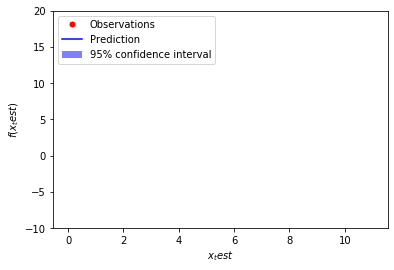

In [136]:
#plt.figure()
#plt.plot(X_test, f(X_test), 'r:', label=r'$f(x) = x\,\sin(x)$')
plt.plot(X, y, 'r.', markersize=10, label='Observations')
plt.plot(X_test, y_pred, 'b-', label='Prediction')
plt.fill(np.concatenate([X_test, X_test[::-1]]),
         np.concatenate([y_pred - 1.9600 * sigma,
                        (y_pred + 1.9600 * sigma)[::-1]]),
         alpha=.5, fc='b', ec='None', label='95% confidence interval')
plt.xlabel('$x_test$')
plt.ylabel('$f(x_test)$')
plt.ylim(-10, 20)
plt.legend(loc='upper left')

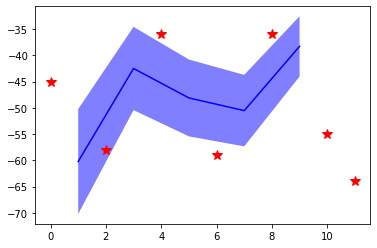

In [142]:
plt.figure
plt.plot(X, y,'r*',markersize=10, label='Observations')
plt.plot(X_test, y_pred, 'b-', label='Prediction')
plt.fill(np.concatenate([X_test, X_test[::-1]]),
         np.concatenate([y_pred - 1.9600 * sigma,
                        (y_pred + 1.9600 * sigma)[::-1]]),
         alpha=.5, fc='b', ec='None', label='95% confidence interval')
